# TLS identification

In [1]:
import matplotlib
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage import io
from skimage import measure
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
import json
from skimage.filters import threshold_multiotsu
from skimage.transform import rescale, resize, downscale_local_mean

In [2]:
import matplotlib
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial']

## Specify input and output file

In [3]:
# deconvolution file generated by STRIDE
sample = "2D"
deconv_dir = "New_STRIDE_LUSC_top88_malignant_cycling"
deconv_file = os.path.join("ST", sample, deconv_dir, "%s_spot_celltype_frac.txt" % sample)
deconv_df = pd.read_csv(deconv_file, sep = "\t", index_col = 0)

# spot location file generated by Spaceranger
st_loc_file = os.path.join("ST", sample, "st_loc_df.txt")
st_df = pd.read_csv(st_loc_file, sep = "\t", index_col = 0)

# scale factor file generated by Spaceranger
rescale_factor_dict = json.load(open(os.path.join("ST", sample, "Spaceranger/spatial/scalefactors_json.json"), "r"))
rescale_factor = rescale_factor_dict['tissue_hires_scalef']

# H&E image
img = io.imread(os.path.join("ST", sample, "Spaceranger/spatial/tissue_hires_image.png"))
img_sub = img

# tls output file
out_dir = "Result_20220412/3_TLS/Result"
tls_loc_file = os.path.join(out_dir, "%s_TLS_loc_label_20220615.txt" % sample)

## Image processing

### Convert original image to grayscale

Before we recognize pattern from tumor H&E images, we firstly need to convert original image to grayscale for downstream processing.

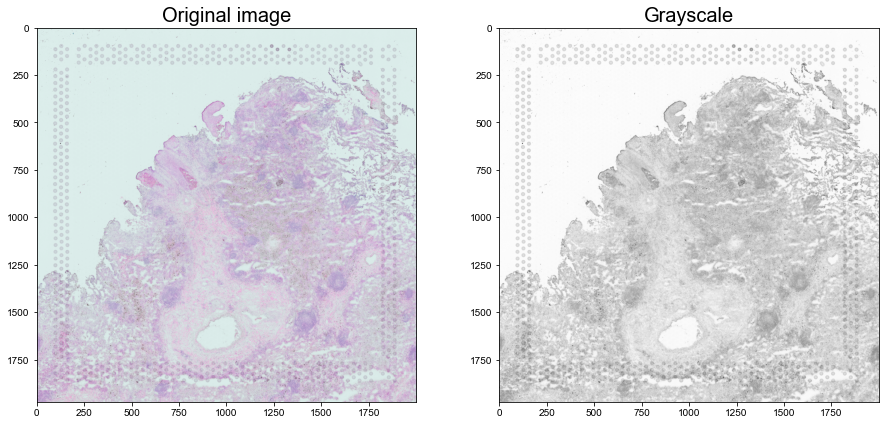

In [4]:
# convert original image to grayscale
lum = color.rgb2gray(img_sub)
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
ax1, ax2 = ax.ravel()
ax1.imshow(img_sub)
ax1.set_title("Original image", fontsize=20)
ax2.imshow(lum, cmap="gray")
ax2.set_title("Grayscale", fontsize=20)
plt.tight_layout()
plt.show()

### Compute a mask

TLSs are primarily composed of lymphocytes with little cytoplasm, and are organized compactly, resulting in darker purple loci separated from the surrounding brighter pink stroma. Here we compute a mask for the grayscale image through simple thresholding, and the darker loci are extracted as the potential TLSs. 

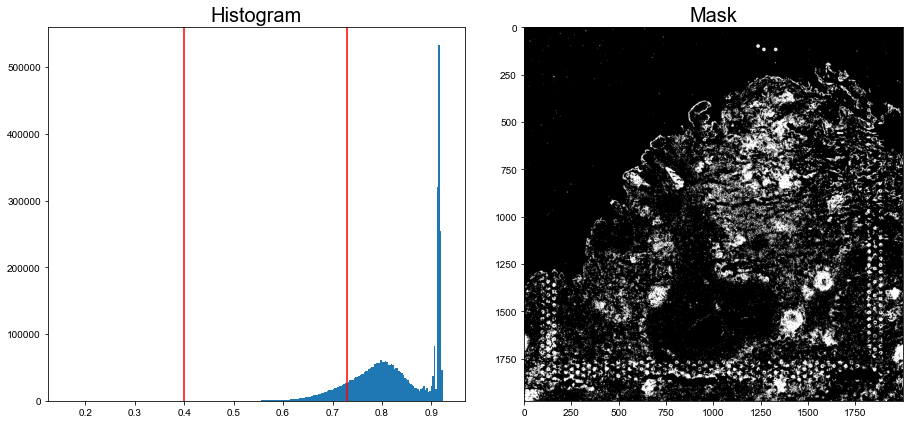

In [5]:
# Compute a mask
thresholds_mult = threshold_multiotsu(lum)
thre_low = 0.4
thre_high = 0.73
thresholds = [thre_low, thre_high]
mask = np.logical_and(lum > thre_low, lum < thre_high)

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
ax1, ax2 = ax.ravel()
ax1.hist(lum.ravel(), bins=255)
for thresh in thresholds:
    ax1.axvline(thresh, color='r')
ax1.set_title('Histogram', fontsize=20)
ax2.imshow(mask, cmap="gray")
ax2.set_title('Mask', fontsize=20)
plt.tight_layout()
plt.show()

### Remove small objects and fill holes

Thresholding results in many small isolated objects which possible are noise and should be removed. Similarly, thresholding may generate some holes which should be filled to make  the identified objects solid. 

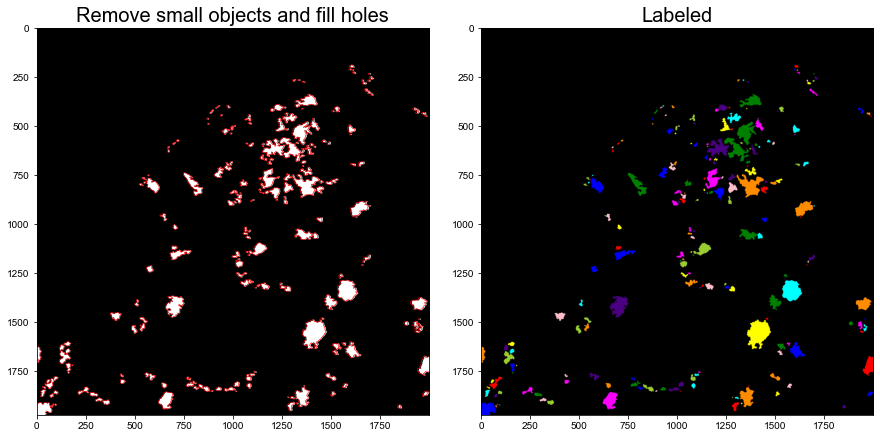

In [6]:
# mask = morphology.closing(mask, morphology.disk(3))
# Remove small objects and Fill holes
mask_filled = morphology.remove_small_holes(
    morphology.remove_small_objects(mask, 500),
    800)  
mask_filled = morphology.opening(mask_filled, morphology.disk(3))
# mask_filled = morphology.erosion(mask_filled, morphology.disk(5))
mask_filled_label = measure.label(mask_filled, connectivity = 2)

fig, ax = plt.subplots(1, 2, figsize=(12.5, 6))
ax1, ax2 = ax.ravel()
ax1.imshow(mask_filled, cmap="gray")
ax1.contour(mask_filled, colors='r', linewidths=0.1)
ax1.set_title("Remove small objects and fill holes", fontsize=20)
ax2.imshow(color.label2rgb(mask_filled_label, bg_label=0))
ax2.set_title("Labeled", fontsize=20)
plt.tight_layout()
plt.show()

### Scale and expand

To combine H&E image and matched ST data, we need to convert pixel positions in the H&E imgae to pixel positions in ST slides. Given that one spot in a ST slide may cover part of TLSs, we also expand the label regions (connected components) outwards by up to 25 pixels in order to include as many as possible TLS-related spots.

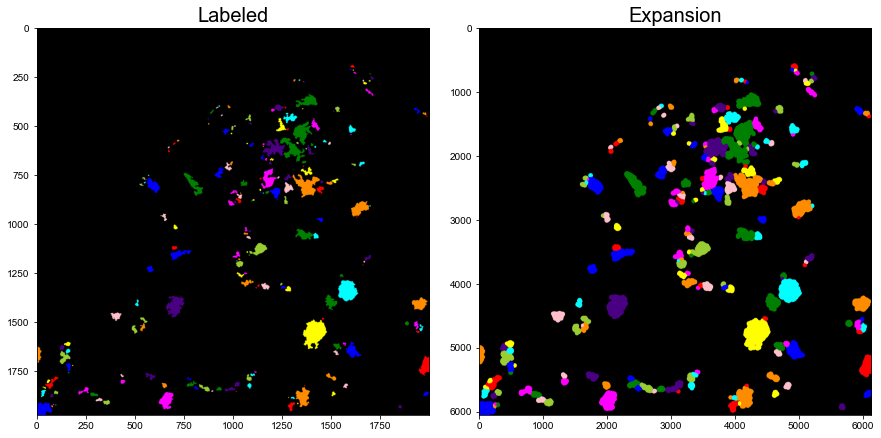

In [7]:
# scale and expand
mask_filled_scaled = rescale(mask_filled, 1/rescale_factor, anti_aliasing=False)
mask_filled_scaled_label = measure.label(mask_filled_scaled)
mask_filled_scaled_label_expanded = segmentation.expand_labels(mask_filled_scaled_label, distance=25)

fig, ax = plt.subplots(1, 2, figsize=(12.5, 6))
ax1, ax2 = ax.ravel()
ax1.imshow(color.label2rgb(mask_filled_label, bg_label=0))
ax1.set_title("Labeled", fontsize=20)
ax2.imshow(color.label2rgb(mask_filled_scaled_label_expanded, bg_label=0))
ax2.set_title("Expansion", fontsize=20)
plt.tight_layout()
plt.show()

## Filter out objects with low proportion of lymphocytes

For each labeled object, we calculated the average proportion of lymphocytes (i.e., B and T cells). Only objects with higher proportion of lymphocytes and with over one spot are considered as TLSs. 

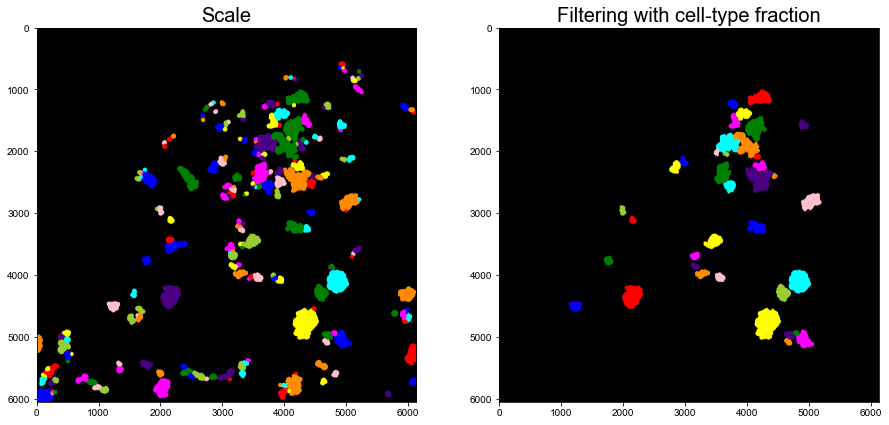

In [8]:
# combine deconvolution results 
st_df['Label'] = [mask_filled_scaled_label_expanded[st_df.loc[i, "X"], st_df.loc[i, "Y"]] for i in st_df.index]
st_df['B'] = deconv_df.loc[st_df.index, 'B']
st_df['T'] = deconv_df.loc[st_df.index, 'T']
st_df['Plasma'] = deconv_df.loc[st_df.index, 'Plasma']
st_df['Lymphocyte'] = deconv_df[['B', 'T']].sum(axis = 1)
label_mean_df = st_df.groupby('Label').mean()
label_count_df = st_df.groupby('Label').count()
tls_label = label_mean_df.index[np.logical_and(np.logical_and(label_mean_df['Lymphocyte'] > 0.15, 
                                               label_count_df['Lymphocyte'] > 1), 
                                              label_mean_df['B'] > 0.1)]
mask_filled_scaled_tls = mask_filled_scaled_label_expanded.copy()
mask_filled_scaled_tls[np.isin(mask_filled_scaled_tls, tls_label, invert=True)] = 0

fig, ax = plt.subplots(1, 2, figsize=(13, 6))
ax1, ax2 = ax.ravel()
ax1.imshow(color.label2rgb(mask_filled_scaled_label_expanded, bg_label=0))
ax1.set_title("Scale", fontsize=20)
ax2.imshow(color.label2rgb(mask_filled_scaled_tls, bg_label=0))
ax2.set_title("Filtering with cell-type fraction", fontsize=20)
plt.tight_layout()
plt.show()

## Write out the location TLS-covered pixels

In [9]:
x_or_list = np.where(mask_filled_scaled_tls)[0].tolist()
y_or_list = np.where(mask_filled_scaled_tls)[1].tolist()
df = pd.DataFrame({'X': x_or_list, 'Y': y_or_list, 'Label': mask_filled_scaled_tls[mask_filled_scaled_tls > 0]})
df.to_csv(tls_loc_file, sep = "\t", index = False)